---

# Tracking multiple particles in a beamline.

Exercises to track multiple particles in beamlines (exercises 11-17).

---

In [1]:
# Import custom tracking functions and useful libraries
from tracking_library import *

# Set up plotting
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Exercise 11 (guided)

Define an ensemble of 1000 particles with an arbitrary first order ($x_0 = 0.2$ mm, $x'_0 = 1$ mrad) and second order momenta($\sigma_{x_0}$ and $\sigma_{x'_0}$).
Verify that the angular divergence of the beam is the one set: 

- what do you observe?
- What happens if you increase or decrease the number of particles?

**Hint:** Remember that you can create a Normal distributed 2xN 2D array of numbers as `np.random.randn(2, N)`. One can then "stretch" and "offset" (and eventually "rotate", but this is not requested here) this distribution to obtain any desired 2D normal distribution in phase space.

#### SOLUTION

In [2]:
# simple solution
N_particles = 1000
beam = np.array([np.random.randn(N_particles),
                 np.random.randn(N_particles)])
# or equivalently:
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0
print(f'Beam mean  x [mm]: {np.mean(beam[0,:])}')
print(f"Beam mean  x' [mrad]: {np.mean(beam[1,:])}")
print(f'Beam rms size [mm]: {np.std(beam[0,:])}')
print(f"Beam rms divergence [mrad]: {np.std(beam[1,:])}")

Beam mean  x [mm]: 0.18634316558632658
Beam mean  x' [mrad]: 0.9808005226418781
Beam rms size [mm]: 1.4083503129547452
Beam rms divergence [mrad]: 0.5145197639003408


> **NOTE:** We did not find back the rms values and offsets that we initially set (e.g. 0.5 for $\sigma_{x'_0}$) due to the statistical error coming with the finite numbers of particles. We can explore the dependence of the statistical error with on the beam divergence by a numerical simulation.

Text(0.5, 1.0, 'Exercise 12')

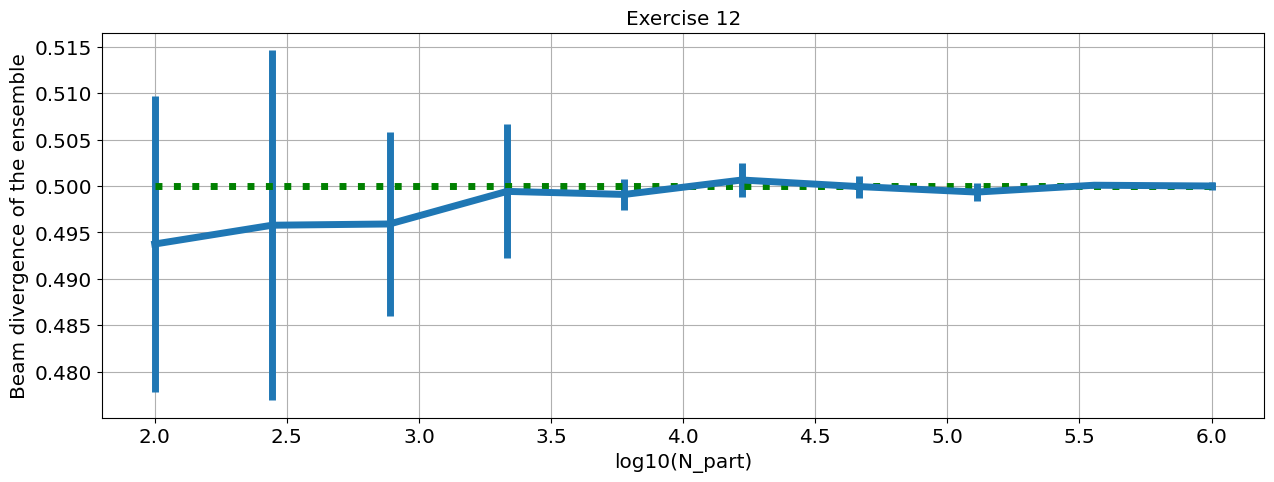

In [3]:
myDivergence = []
myDivergenceStatisticalError = []
Npart_range = np.round(np.logspace(2,6,10))
Npart_range = Npart_range.astype(int)
for Npart in Npart_range:
    aux = []
    for j in range(10):
        beam = np.random.randn(2, Npart)
        beam[0,:] = sigx*beam[0,:]+x0
        beam[1,:] = sigxp*beam[1,:]+xp0
        aux.append(np.std(beam[1,:]))
    myDivergence.append(np.mean(aux))
    myDivergenceStatisticalError.append(np.std(aux))
plt.errorbar(np.log10(Npart_range),myDivergence,myDivergenceStatisticalError,lw=5)
plt.plot([2,6],[sigxp,sigxp],':g',lw=5)
plt.grid(True)
plt.xlabel('log10(N_part)')
plt.ylabel('Beam divergence of the ensemble')
plt.title('Exercise 12')

> **Depending on the required precision we need to select a convenient number of particles to model our beams!**

### Exercise 12

1. Transport the beam distribution of [Exercise 12](#exercise-12-guided) in a drift of length 1 m. Visualise the initial and final distribution. What do you observe?

   **Hint:** One can use the `seaborn` package to nicely see a 2D distribution, e.g.:
   ```
   import seaborn as sns
   sns.jointplot(x=np.random.randn(1000), y=np.random.randn(1000), kind="hex", color="b")
    
   ```

3. Test of linearity.  Scale the input vector by 17 times the month of your birthday (e.g. 85 if you are born in May) and verify that the output vector from the matrix multiplication has changed by the same factor.
    
    **Hint:** Be careful with machine precision!

4. Consider 3 particles (e.g. the first 3 of your ensample) such that they define a triangle of surface A. Verify that this linear transport preserve the area of the triangle.

    **Hint:** the area of a triangle in phase space can be computed using linear algebra:
    ```
    from numpy.linalg import norm
    def area(a, b, c) :
        '''a,b,c are the phase-space coordinates of three particles'''
        return 0.5 * norm( np.cross( b-a, c-a ) )
    ```

#### SOLUTION - transport

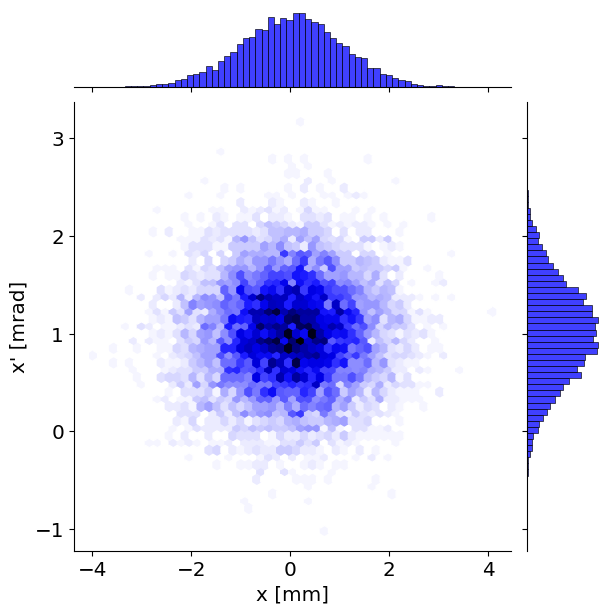

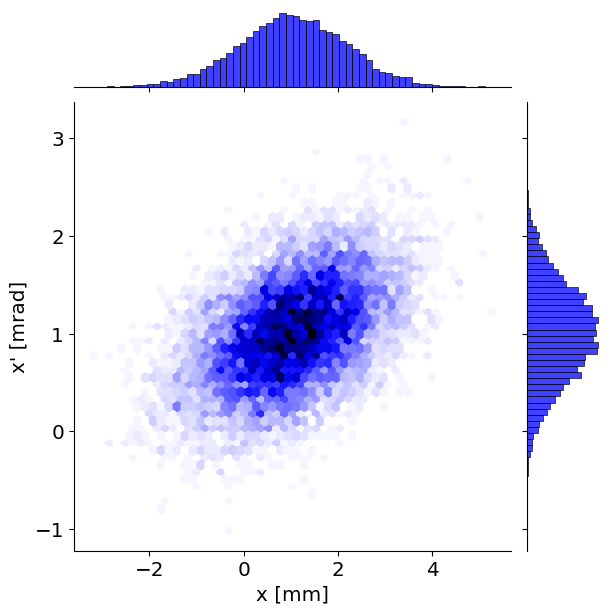

In [4]:
# code here your solution...
Npart = 10000
beam = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1
sigxp = 0.5
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

beam_after_drift = D(1)[0]['matrix'] @ np.array(beam)

# Before the drift
g = sns.jointplot(x=beam[0,:], y=beam[1,:], kind="hex", color="b")
g.set_axis_labels("x [mm]", "x' [mrad]")
#g.savefig('before_drift.pdf')

# After the drift
g = sns.jointplot(x=beam_after_drift[0,:], y=beam_after_drift[1,:],
                  kind="hex", color="b")
g.set_axis_labels("x [mm]", "x' [mrad]")
#g.savefig('after_drift.pdf')

> **Note that the distribution in phase space is now a "tilted" ellipse!**

#### SOLUTION - test of linearity

In [5]:
# code here your solution...
month_birthday = 3
v1 = D(1)[0]['matrix']@(17*month_birthday*beam)
v2 = 17*month_birthday*D(1)[0]['matrix']@(beam)

# this might return False due to machine precision rounding - See **Computational tools** course!:
print(np.array_equal(v1,v2))
# let's compare at the level of 10 times epsilon, times the scaling factor used for the test
print(np.max(np.abs(v1-v2)) < 10*17*month_birthday*np.finfo(v1.dtype).eps)

True
True


#### SOLUTION - area preservation

Now let us consider three points of the distributions and let us verify that the area of the triangle before and after the transoformation is preserved.

**IMPORTANT**: the area preservation is a condition stronger than the linearity. It is possible only for special matrices, the so-called symplectic matrices.
A $2\times2$ matrix is symplectic if and only if its determinant is one.

In [6]:
# this is the formula of the area of a triangle
from numpy.linalg import norm
def area(a, b, c) :
    '''a,b,c are the phase-space coordinates of three particles'''
    return 0.5 * norm( np.cross( b-a, c-a ) )

In [7]:
# code here your solution...
# we take the first three particles in the beam (arbitrary choise)
print(f"Before transport {area(beam[:,0],beam[:,1],beam[:,2])}")
print(f"After transport {area(beam_after_drift[:,0],beam_after_drift[:,1],beam_after_drift[:,2])}")

Before transport 0.5586419531145043
After transport 0.5586419531145043


We can visualise this in a plot:

Text(0.5, 1.0, 'Exercise 13')

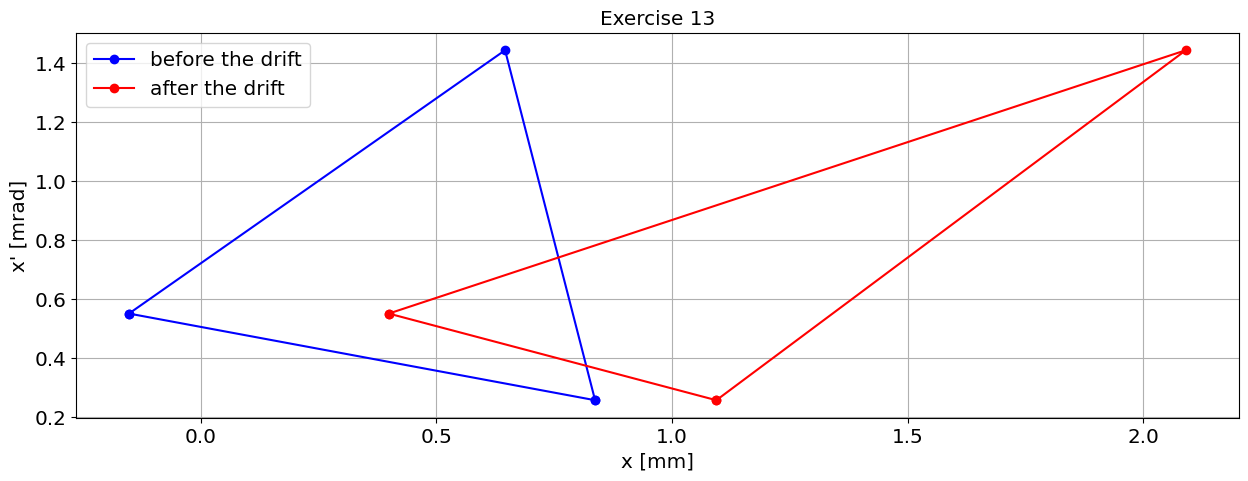

In [8]:
#first triangle
plt.plot(beam[:,:3][0],beam[:,:3][1],'o-b')
plt.plot(beam[:,[2,0]][0],beam[:,[2,0]][1],'o-b', label='before the drift')

#second triangle
plt.plot(beam_after_drift[:,:3][0],beam_after_drift[:,:3][1],'o-r')
plt.plot(beam_after_drift[:,[2,0]][0],beam_after_drift[:,[2,0]][1],'o-r',label='after the drift')

plt.legend()
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.grid(True)
plt.title('Exercise 13')

### Exercise 13
Using the 5 FODO cells of [Exercise 9](#exercise-9), transport the beam of [Exercise 13](#exercise-13) and plot the beam $size$ ($\sigma_x$) and $divergence$ ($\sigma_{x'}$) along the beam line.

**Hint:** Remember that in the output of our `transportParticles` function the key `'x'` contains a 2D array with N rows (the index of the position along the beam line) and M columns (the index of a given particle). 
Moreover, you can compute the standard deviation of **each raw** of a NxM 2D array as `np.std(N_times_M_array,1)`. 

#### SOLUTION

Text(0.5, 1.0, 'Exercise 14')

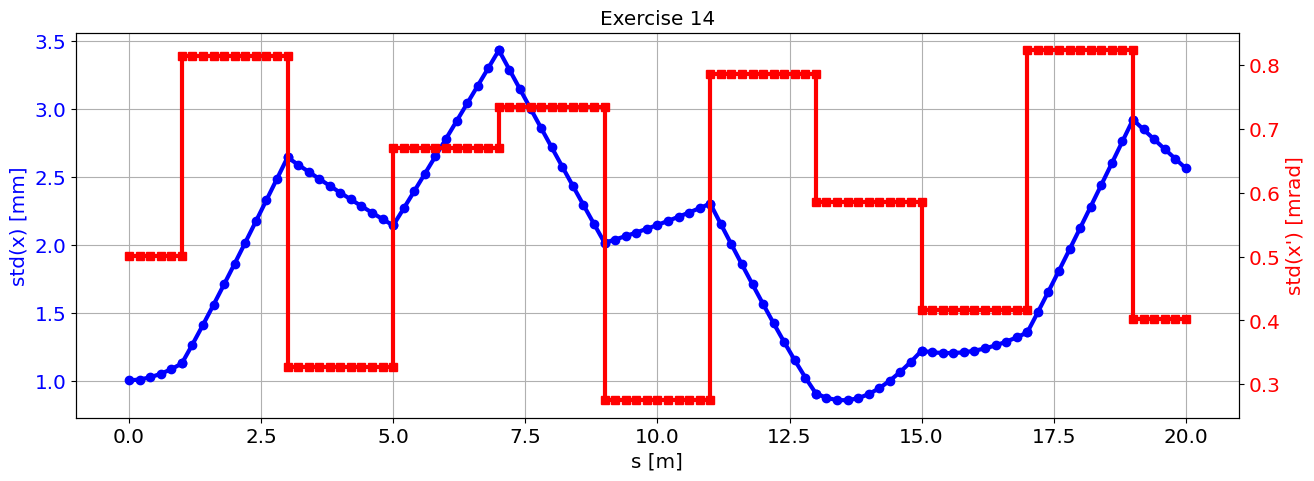

In [9]:
# code here your solution...
#prepare the optics
f = 2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10)+Q(-f)+10*D(L_2/10)+Q(f)+5*D(L_2/10)

#prepare the beam
Npart = 10000
beam = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1
sigxp = 0.5
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

transported_particles = transportParticles(beam, 5*fodo_lattice)

plt.plot(transported_particles['s'], np.std(transported_particles['x'],1), 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('std(x) [mm]', color='b')
plt.tick_params(axis='y', labelcolor='b')

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel("std(x') [mrad]", color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.plot(transported_particles['s'], np.std(transported_particles['xp'],1), 's-r', lw=3)
#plt.savefig('exercise14.pdf')
plt.title('Exercise 14')

---

### Interlude: track of sigma matrices

---

One can easily demonstrate (see [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/)) that the same matrix ($M$) used for tracking the coordinates ($(x_i, x'_i)$) of each single particle ($i$) from an initial point ($X_0$) to a final point ($X_s$) in a beamline:

\begin{equation}
X_s =  M\, X_0
\end{equation}

can also be used to track the **average trajectory** ($\langle X \rangle$) as well as the **covariance or sigma matrix** of the given particle coordinates distribution:

\begin{equation}
\langle X_s \rangle = 
\left[
\begin{array}{c}
\langle x_i \rangle\\
\langle x'_i \rangle
\end{array}
\right]_s 
= M\, \langle X_0 \rangle
\end{equation}

\begin{equation}
\Sigma_s = \left[
\begin{array}{c}
\sigma_{xx}\quad \sigma_{xx'}\\
\sigma_{x'x}\quad \sigma_{x'x'}
\end{array}
\right]_s
= M\, \Sigma_0\, M^T\, .
\end{equation}

We can therefore track the **average trajectory** and **covariance** of a beam simply starting from its initial average coordinates and covariance matrix in phase space.

We can write a simple function that tracks the sigma matrix along a beamline:

In [10]:
def transportSigmas(sigma_0, beamline):
    '''Transport the input sigma matrix (sigma_0) along the given beamline
    
    It will return a dictionary containing the following key:values
        'sigma11': a N-long numpy array with the \sigma_{11} value for all N-elements of the beamline
        'sigma12': a N-long numpy array with the \sigma_{12} value for all N-elements of the beamline
        'sigma21': a N-long numpy array with the \sigma_{21} value for all N-elements of the beamline
        'sigma22': a N-long numpy array with the \sigma_{22} value for all N-elements of the beamline
        's': a N-long numpy array with the longitudinal position of the N-elements of the beamline
        'sigmas': a Nx2x2 numpy array with all sigma matrices at all N-elements of the beamline
    
    Disclaimer: if beamline is made of 5 elements, the output will have 5+1 "elements" as it will also 
                return include the initial sigma matrix.
    '''

    sigmas = [sigma_0]
    s = [0]
    for element in beamline:
        sigmas.append(element['matrix'] @ sigmas[-1] @ element['matrix'].transpose())
        s.append(s[-1] + element['length']) 
    sigmas = np.array(sigmas)
    s = np.array(s)
    return {'sigma11': sigmas[:, 0, 0],
            'sigma12': sigmas[:, 0, 1],
            'sigma21': sigmas[:, 1, 0], # equal to sigma12
            'sigma22': sigmas[:, 1, 1],
            's':  s,
            'sigmas': sigmas,}

---

### Let's put this in practice

---

### Exercise 14

Show that the average position of a beam made of 100 particles along a beam line (e.g. our usual beamline made of 5 FODO cells) is the same as the the trajectory of single particle particle that starts in the center of the initial particle distribution.

#### SOLUTIONS

Text(0.5, 1.0, 'Exercise 15')

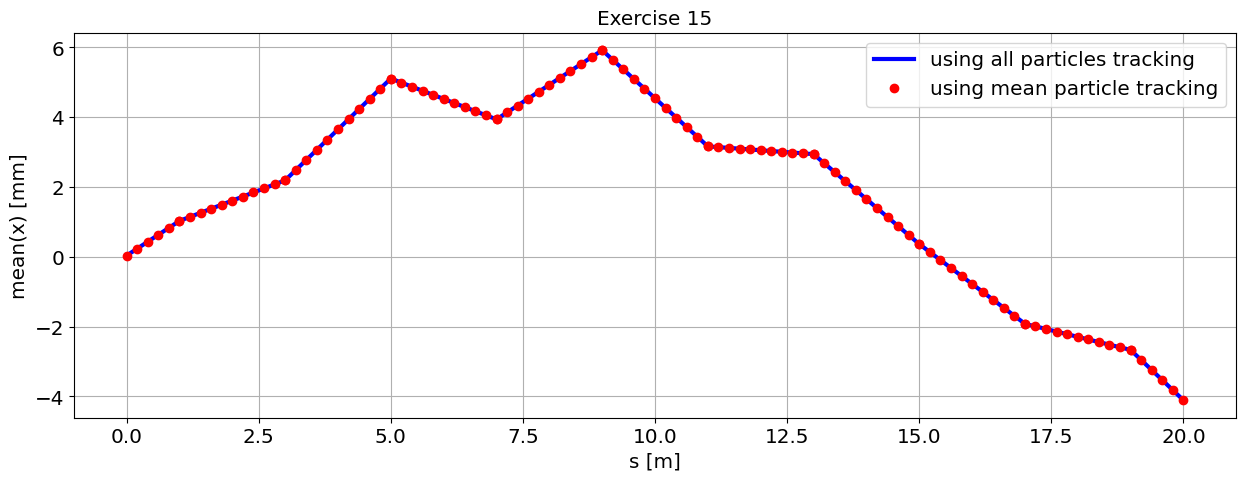

In [11]:
# code here your solution...
#lattice
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

#prepare the beam
Npart = 1000
beam0 = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1 
sigxp = 0.2
beam0[0,:] = sigx*beam0[0,:] + x0
beam0[1,:] = sigxp*beam0[1,:] + xp0

# transport all particles 
transported_particles = transportParticles(beam0, 5*fodo_lattice)
# transport only the average position
mean_particle = np.array([[np.mean(beam0[0,:])], [np.mean(beam0[1,:])]])
transported_mean = transportParticles(mean_particle, 5*fodo_lattice)

plt.plot(transported_particles['s'], np.mean(transported_particles['x'],1), '-b', lw=3, label='using all particles tracking')
plt.plot(transported_mean['s'], transported_mean['x'], 'or', lw=3, label='using mean particle tracking')
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('mean(x) [mm]')
plt.legend()

# For saving the figure
#plt.savefig('exercise_15.pdf')
plt.title('Exercise 15')

### Excercise 15

For the same system as before, compare the rms beam size computed from tracking all particles and from using the sigma matrix approach.

**Note:** Is this valid for any number of initially tracked particles? How does the result change if one uses the **input** covariance matrix used to generate the particle distribution rather then the **actual** covariance matrix of the generated distribution?

**Hint 1:** Remember that the element $\sigma_{xx}$ of the covariance matrix is linked to the rms beam size ($\sigma_x$) as $\sigma_x = \sqrt{\sigma_{xx}}$.

**Hint 2:** The covariance matrix of a 2xN array can be computed using `numpy` as `np.cov(2_times_N_array, bias=True)`.

Text(0.5, 1.0, 'Exercise 16')

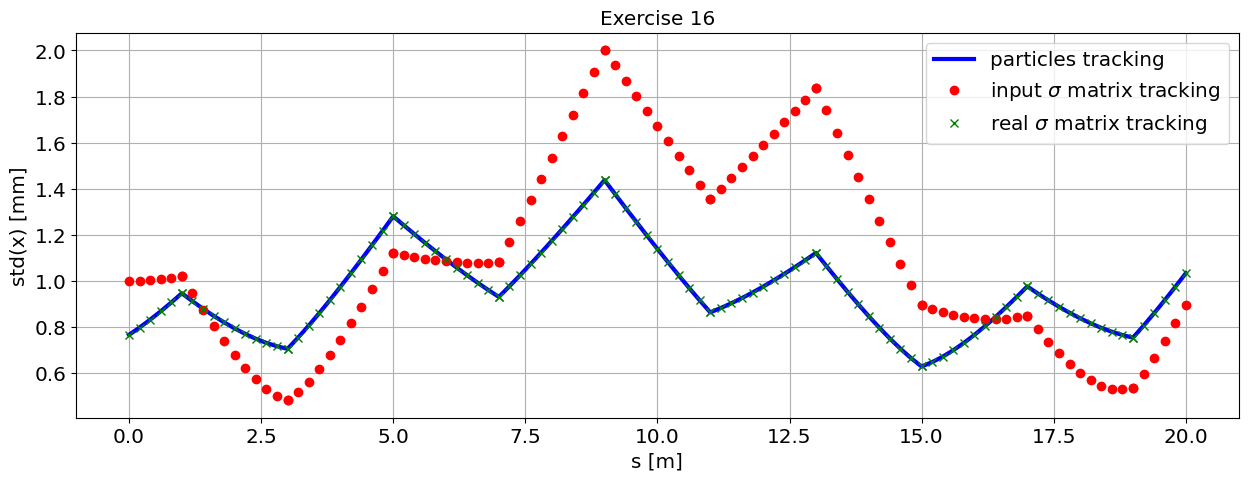

In [12]:
# code here your solution...
#lattice
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

#prepare the beam
Npart = 10
beam0 = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1 
sigxp = 0.2
beam0[0,:] = sigx*beam0[0,:] + x0
beam0[1,:] = sigxp*beam0[1,:] + xp0

#prepare the sigma matrix based on our inputs:
sigma_0 = np.array([[sigx**2, 0], [0, sigxp**2]])
# alternative: if we use the covariance matrix of the generated distribution:
sigma_real = np.cov(beam0, bias=True)

# transport all particles:
transported_particles = transportParticles(beam0, 5*fodo_lattice)
# transport the sigma matrix only:
transported_sigmas = transportSigmas(sigma_0, 5*fodo_lattice)
transported_real_sigmas = transportSigmas(sigma_real, 5*fodo_lattice)

# plot all estimation of beam size:
plt.plot(transported_particles['s'],   np.std(transported_particles['x'],1), '-b', lw=3, label='particles tracking')
plt.plot(transported_sigmas['s'],      np.sqrt(transported_sigmas['sigma11']), 'or', lw=3, label='input $\sigma$ matrix tracking')
plt.plot(transported_real_sigmas['s'], np.sqrt(transported_real_sigmas['sigma11']), 'xg', lw=3, label='real $\sigma$ matrix tracking')
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('std(x) [mm]')
plt.legend()

# For saving the figure
#plt.savefig('exercise_16.pdf')
plt.title('Exercise 16')

> It is important to observe that the result of from the particle tracking and the sigma matrix tracking are equivalent.
The small deviation is due to the statistical noise of the ensemble (it can be reduced by increasing the number of particles).
This deviation is zero (or numerical) if one tracks the actual covariance matrix of the ensemble of the generated particles. (Note that the `bias=True` option to numpy `cov` function is necessary to force the simple (bias) computation of the covariance)
> 
> Clearly, the sigma matrix tracking is computationally cheaper than the particle tracking (if Npart>>1).

---
## Introduction of Twiss values and emittance
---

The sigma/covariance matrix of any particle distribution can also be written as:

\begin{equation}
\Sigma = 
    \left[
    \begin{array}{cc}
    \sigma_{xx}  & \sigma_{xx'}\\
    \sigma_{x'x} & \sigma_{x'x'}
    \end{array}
    \right] =
    \epsilon
    \left[ 
    \begin{array}{cc}
        \beta   & -\alpha\\
        -\alpha & \gamma
    \end{array}
    \right] 
\end{equation}

where $\beta$, $\alpha$, $\gamma$ and $\epsilon$ are parameters such that $\epsilon = \sqrt{\det(\Sigma)}$ and $\beta \gamma - \alpha^2 = 1$. 

**This seems to be an arbitrary choice!** but it will acquire more special meaning later.

In the meantime, recall once more that:

\begin{equation}
\Sigma_{s} = M\, \Sigma_{0}\, M^T\, .
\end{equation}

where $M$ is a real **symplectic** transformation, and its determinant is $\det(M) = +1$, therefore:

\begin{equation}
\epsilon_s = \det(\Sigma_s) = \det( M\, \Sigma_0\, M^T ) = \det(M) \det(\Sigma_0) \det(M^T) = \det(\Sigma_0) = \epsilon_0
\end{equation}

which means that the quantity $\epsilon$ (the beam **statistical emittance**) is **preserved** along a beamline!!!

### Exercise 16
Verify that the equivalent transport matrix of any beamline, e.g. our usual FODO cell, has determinant equal to 1.

**Hint:** you can use `np.linalg.det(my_matrix)` to compute the determinant of a matrix `my_matrix`

#### SOLUTION

In [13]:
# code here your solution...
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)
OTM = getEquivalentElement(fodo_lattice)
print(f'The determinant of the FODO OTM is {np.linalg.det(OTM[0]["matrix"])}.')

The determinant of the FODO OTM is 1.000000000000001.


### Exercise 17

Consider our usual FODO cell, and create a valid sigma matrix with:
- $\beta$ = 3 [m]
- $\gamma$ = 0.5 [1/m]
- $\epsilon$ = 5 [$\mu$ m]

Then, propagate the $\sigma$ matrix through the beam line and verify that the emittance $\epsilon$ of the sigma matrix after every element is indeed constant and equal to its initial value.

**Optional:** compute and plot the **beta** function all along the beamline. 

**Hint:** in the output of our `transportSigmas()` function we keep all sigma matrixes. The determinant of all matrices can be computed in one go as `np.linalg.det(transported_sigmas['sigmas'])`.

#### SOLUTION

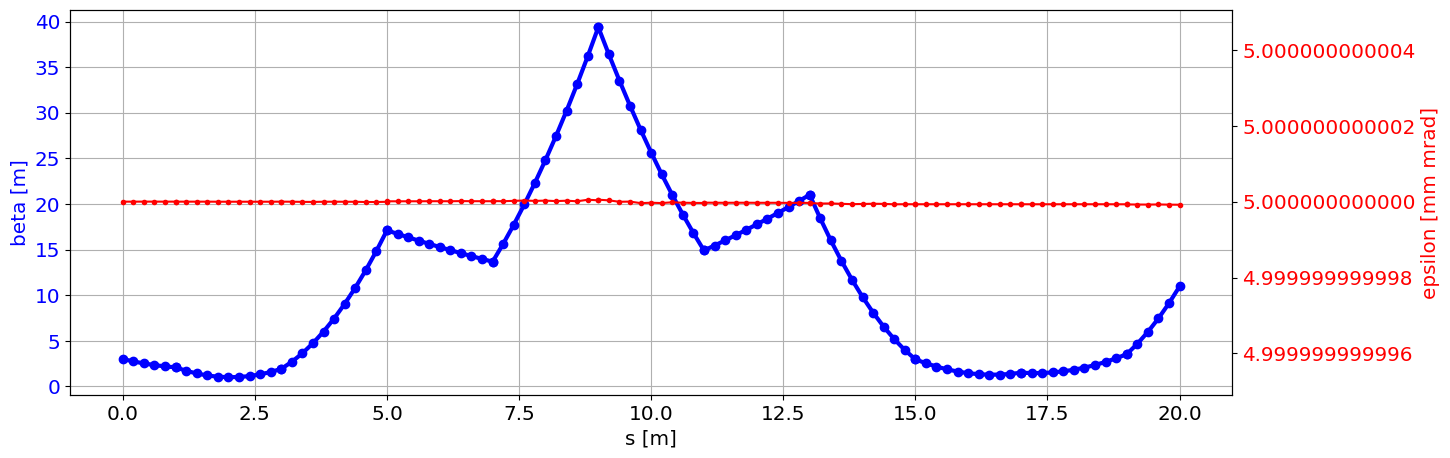

In [14]:
# code here your solution...
#lattice
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

# let's create a simple sigma matrix
beta0 = 3
gamma0 = 0.5
epsilon0 = 5
# alfa must be:
alfa0 = np.sqrt(beta0*gamma0 - 1)
sigma_0 = epsilon0 * np.array([[beta0, -alfa0], [-alfa0, gamma0]])

# transport the sigma matrix:
transported_sigmas = transportSigmas(sigma_0, 5*fodo_lattice)

# compute the emittance as sqrt of the determinant of all sigma matrices along 
# the beamline
emittance = np.sqrt(np.linalg.det(transported_sigmas['sigmas']))
# the beta function can be extracted as well from the 'sigma11' element, 
# divided by the emittance
beta = transported_sigmas['sigma11']/emittance

# make a simple plot
plt.plot(transported_sigmas['s'], beta, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('beta [m]', color='b')
plt.tick_params(axis='y', labelcolor='b')

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel("epsilon [mm mrad]", color='r')
plt.tick_params(axis='y', labelcolor='r')
plt.plot(transported_sigmas['s'], emittance,'.-r')
plt.ticklabel_format(useOffset=False)